# Find the varying delay between the Joystick and upper camera for alignment
1. First get the csv file from deeplabcut. if it doesn have all the frames annotation in it use the notebook ConvertDLCresult_to_readableCSV
2. If the points in DLC csv file need reordering use permutation cell here
3. if the Outliers are not excluded in csv use the compute_length function to kick them out
4. Get the scale of upper camera wrt Joystick and add it in the measuring_length_...txt file. Use `convert_frnum_to_time` function to find the estimation of correspondence between upper camera recording and joystick time stamps
5. use four different delay time for each 50 or 100 frames and compare the aligned masks (plots of cell 5) wrt them to see which delay is correct.
6. recorde the delay corresponding to each interval of upper camera frames in measuring_length_...txt file
7. use the derived delays in the AlignUppeCamera_Joystick notebook to align the upper camera masks

In [209]:
import os
import sys
import csv
import numpy as np
import h5py
import pandas as pd
import datetime
from matplotlib import style
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import splrep, BSpline

In [304]:
joysticklog_address ='../log_2024_09_17_12_01_06.txt'
csvFile_address = './PostProcess/6000after/CollectedData_Mahsa.csv'
AddressOut = joysticklog_address.split(".")
AddressOut = AddressOut[0]
csvFile_Out = csvFile_address.split(".")
csvFile_Out = csvFile_Out[1]

start_delay = 000000#delay of upper camera from its time stamp in microseconds

Delay1 = datetime.timedelta(hours=0, minutes=0, seconds=0,microseconds=900000)
Delay2 = datetime.timedelta(hours=0, minutes=0, seconds=0,microseconds=950000)
Delay3 = datetime.timedelta(hours=0, minutes=0, seconds=1,microseconds=000000)
Delay4 = datetime.timedelta(hours=0, minutes=0, seconds=1,microseconds=50000)

In [305]:
file = open(csvFile_address)

csvreader = csv.reader(file)
np.shape(csvreader)
rows = []

for row in csvreader:
    rows.append(row)

### Functions:

In [306]:
def compute_lenth(points_vector):
    #point_vector is in the format [x1,y1,x2,y2,x3,y3,x4,y4,...]
    points_array = np.array(points_vector).reshape(-1, 2)

    # Compute the length spanned by the points
    total_length = 0.0

    for i in range(len(points_array) - 1):
        x1, y1 = points_array[i]
        x2, y2 = points_array[i + 1]
        segment_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        total_length += segment_length
    return total_length    

def convert7to20(Xcoord,Ycoord):
    t = np.linspace(0, 6, len(Xcoord))

    # Create cubic spline interpolators for x and y as functions of t
    spline_x = interp1d(t, Xcoord, kind='cubic')
    spline_y = interp1d(t, Ycoord, kind='cubic')

    # Create new parameterization for the 20 equally spaced points
    new_t = np.linspace(0, 6, 20)

    # Calculate the 20 points' x and y coordinates
    new_x = spline_x(new_t)
    new_y = spline_y(new_t)
    return new_x, new_y

def convert7to20smooth(Xcoord,Ycoord,sm=0):
    t = np.linspace(0, 6, len(Xcoord))

    tckx = splrep(t, Xcoord, s=sm,k=2)
    tcky = splrep(t, Ycoord, s=sm,k=2)

    # Create new parameterization for the 20 equally spaced points
    new_t = np.linspace(0, 6, 20)

    # Calculate the 20 points' x and y coordinates
    new_x = BSpline(*tckx)(new_t)
    new_y = BSpline(*tcky)(new_t)
    return new_x, new_y


def extract_coordinates(Address,num=3):
    #returns the data in csv file
    file = open(Address)
    type(file)
    csvreader = csv.reader(file)
    np.shape(csvreader)
    rows = []

    for row in csvreader:
        rows.append(row)
        
    print(np.shape(rows))
    
    if num==3:
        rowsArr0=np.array(rows[3:])
        rowsArr=np.array(rowsArr0[:,3:])
        #print(rowsArr)
    else:
        rowsArr=np.array(rows)
        
    
    shapeMat = np.shape(rowsArr)
    print(shapeMat)
    rowsArr_float = np.zeros(shapeMat)
    for i in range(shapeMat[0]-1):
        for j in range(shapeMat[1]): 
            try:
                rowsArr_float[i,j]=float(rowsArr[i,j])   
            except ValueError:  
                rowsArr_float[i,j]= np.nan
    return rows,rowsArr_float

def smooth_locations(rowsArr_floatloc1,dtype=0,sig=1,inter=0):
    smoothed_arr=np.zeros(np.shape(rowsArr_floatloc1))
    for t in range(np.shape(rowsArr_floatloc1)[1]):
        if inter:
            smoothed_arr[:,t] = gaussian_filter(interpolate_outlier(rowsArr_floatloc1[:,t]), sigma=sig)
        else:
            smoothed_arr[:,t] = gaussian_filter((rowsArr_floatloc1[:,t]), sigma=sig)
    return smoothed_arr 

def every_second_component(vector,odd=0):
    new_vector = []
    if odd==0:
        for i in range(1, len(vector), 2):
            new_vector.append(vector[i])
    else:
        for i in range(0, len(vector), 2):
            new_vector.append(vector[i]) 
    return new_vector  

def convert_frnum_to_time(frnum,Time0 = '0:0:0',fps=4,ms1 = 0):
    (h1, m1, s1) = Time0.split(':')
    
    T0 = datetime.timedelta(hours=int(h1), minutes=int(m1), seconds=int(s1),microseconds=int(ms1))
    sec = int(frnum/fps)
    usec  = (frnum - sec*fps)*10**6/fps
    FinalTime = datetime.timedelta(hours = 0, minutes = 0, seconds = sec ,microseconds = int(usec)) + T0
    formatted_time = str(FinalTime).split(".")[0]  # Remove microseconds part
    print("Formatted time:", FinalTime)
    return FinalTime

# 1. Import upper camera masks 

In [307]:
rows,rowsArr_float = extract_coordinates(csvFile_address,num=3)
#permute points from DLC if they are not ordered
permutation = np.array([0,1, 6,7, 8,9, 4,5, 10,11, 12,13, 2,3])
rowsArr_float2 = rowsArr_float#[:, permutation]
print(np.shape(rowsArr_float))

(12630, 25)
(12627, 22)
(12627, 22)


# 2,3. If you need to perform permutation or kick outliers

In [308]:
lengthVec = np.zeros(len(rowsArr_float2[:,1]))
for t in range(len(lengthVec)):
    lengthVec[t] = compute_lenth(rowsArr_float2[t,:])

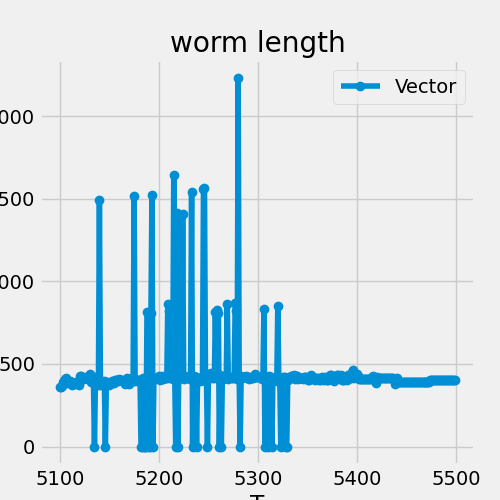

In [309]:
style.use('fivethirtyeight')
# Define the interval 
start_index, end_index = 5100, 5500
# Plot the vector within the specified interval
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(np.arange(start_index, end_index),lengthVec[start_index:end_index], marker='o', label='Vector')
# Add labels and title
plt.xlabel('T')
plt.ylabel('Length')
plt.title('worm length')
# Show grid
plt.grid(True)
# Add legend
plt.legend()
# Show the plot
plt.show()

In [310]:
thresh_len = 500
for t in range(6000):#len(lengthVec)):
    if lengthVec[t]>thresh_len:
        rowsArr_float2[t,:]= np.full(22, np.nan)# change 22 to 14 if you have only 7 points in the masks
    if lengthVec[t]<200:
        rowsArr_float2[t,:]= np.full(22, np.nan)# change 22 to 14 if you have only 7 points in the masks   

df_corr = pd.DataFrame(rowsArr_float2)
df_corr.to_csv(csvFile_Out+"_threshed.csv", index=False, na_rep='NaN',header=False) 

# 4.Continue with the delay correction


## 4.1. extend 7/11 points in upper camera masks to 20 points for better visuals

In [311]:
extended20matrix =np.zeros((len(rowsArr_float2[:,0]),40))
extended20matrixsmooth =np.zeros((len(rowsArr_float2[:,0]),40))
extended20matrixsmooth2 =np.zeros((len(rowsArr_float2[:,0]),40))


for t in range(len(rowsArr_float2[:,0])):
    extended20matrix[t,0::2], extended20matrix[t,1::2] = convert7to20(every_second_component(rowsArr_float2[t,:],1),every_second_component(rowsArr_float2[t,:],0))
    extended20matrixsmooth[t,0::2], extended20matrixsmooth[t,1::2] = convert7to20smooth(every_second_component(rowsArr_float2[t,:],1),every_second_component(rowsArr_float2[t,:],0))
    extended20matrixsmooth2[t,0::2], extended20matrixsmooth2[t,1::2] = convert7to20smooth(every_second_component(rowsArr_float2[t,:],1),
                                                                every_second_component(rowsArr_float2[t,:],0),sm=100)
    

## 4.2. Get the scale of upper camera wrt Joystick from measuring_length_...txt file.
### Use `convert_frnum_to_time` function to find the estimation of correspondence between upper camera times at each frame and joystick time stamps. In this movie (20240917_RIM), the frames 31,32,33 and 44,45,46,55 were used for finding the ration between upper camera pizels and joystick (x,y) stamps. Read the measuring_length_...txt file for specifics.

In [312]:
start_uppercam_time = 151650
fps = 4
pillar_diam = 54#diameters in pixels
pixelsize = 1000/pillar_diam #size of each pixel in tenth of micrometer
ratiox = 1/20#ratio of the upper camera pixel changes to the joystick-computed in measuring_lengths_xxx.txt file
ratioy = 1/17

In [313]:
# to get estimation of the correspondence of frames in upper camera and joystick to getthe length transformation between them
convert_frnum_to_time(31,Time0 = '15:16:50',fps=4,ms1 = 0)
convert_frnum_to_time(32,Time0 = '15:16:50',fps=4,ms1 = 0)
convert_frnum_to_time(33,Time0 = '15:16:50',fps=4,ms1 = 0)

convert_frnum_to_time(44,Time0 = '15:16:50',fps=4,ms1 = 0)
convert_frnum_to_time(45,Time0 = '15:16:50',fps=4,ms1 = 0)
convert_frnum_to_time(46,Time0 = '15:16:50',fps=4,ms1 = 0)
convert_frnum_to_time(55,Time0 = '15:16:50',fps=4,ms1 = 0)
convert_frnum_to_time(1200,Time0 = '15:16:50',fps=4,ms1 = 0)

Formatted time: 15:16:57.750000
Formatted time: 15:16:58
Formatted time: 15:16:58.250000
Formatted time: 15:17:01
Formatted time: 15:17:01.250000
Formatted time: 15:17:01.500000
Formatted time: 15:17:03.750000
Formatted time: 15:21:50


datetime.timedelta(seconds=55310)

## 4.3. Run the alignment for the frames specified in line 77 based on the 4 different delay time you set. Usually I choose intervals of 1000 frames to align at a time.

In [315]:
Time0 = ['15:16:50']#start time of the recording for behavioral camera


T = np.shape(rowsArr_float)[0]

t1 = np.zeros((T))#vector of time points in microsecond unit at each frame


#location of the head in each frame
Head_XY_1 = np.zeros((2,T))


t_xy_v1 =  np.zeros((T,23))#matrix of xy location of 11 points and time at each frame of the behavioral camera
t_xy_v1_ext =  np.zeros((T,41))#matrix of extended point and time points at each frame

t_xy_vd2 =  np.zeros((T,23))#matrix of location and time points at each frame
t_xy_vd2_ext =  np.zeros((T,41))#matrix of extended point and time points at each frame

t_xy_vd3 =  np.zeros((T,23))#matrix of location and time points at each frame
t_xy_vd3_ext =  np.zeros((T,41))#matrix of extended point and time points at each frame

t_xy_vd4 =  np.zeros((T,23))#matrix of location and time points at each frame
t_xy_vd4_ext =  np.zeros((T,41))#matrix of extended point and time points at each frame

with open(joysticklog_address,'r') as f:
    lines = f.readlines()

#read the log file
f = open(joysticklog_address,'r')     
filestr = f.read()  
  
#startInd1 = filestr.index(Time0[0])
#prepare movie's time:
(h1, m1, s1) = Time0[0].split(':')
ms1 = start_delay
mysum1 = datetime.timedelta(hours=int(h1), minutes=int(m1), seconds=int(s1),microseconds=int(ms1))+Delay1
mysum2 = datetime.timedelta(hours=int(h1), minutes=int(m1), seconds=int(s1),microseconds=int(ms1))+Delay2
mysum3 = datetime.timedelta(hours=int(h1), minutes=int(m1), seconds=int(s1),microseconds=int(ms1))+Delay3
mysum4 = datetime.timedelta(hours=int(h1), minutes=int(m1), seconds=int(s1),microseconds=int(ms1))+Delay4

#get time and xy location from h5 file
for t in range(int(T)):
    time = (t/fps)*10**6#corresponding time of each frame in microsceond
    t1[t] = time
#array of time at each frame  in the datetime format for the movie
t_arr1 = np.array([mysum1 + datetime.timedelta(microseconds=int(ms2)) for ms2 in t1])
t_arr2 = np.array([mysum2 + datetime.timedelta(microseconds=int(ms2)) for ms2 in t1])
t_arr3 = np.array([mysum3 + datetime.timedelta(microseconds=int(ms2)) for ms2 in t1])
t_arr4 = np.array([mysum4 + datetime.timedelta(microseconds=int(ms2)) for ms2 in t1])

#initialize the matrix including datetime values for the log file
initialTimeMat = np.array([datetime.timedelta(hours=0, minutes=0, seconds=0,microseconds=0) for i in lines])
#X and Y coordinates of the X box
Xval= np.zeros(len(initialTimeMat))
Yval= np.zeros(len(initialTimeMat))

for i in range(len(lines)):
    (time,xy) = lines[i].split('  ')
    (x,y) = xy.split(' ')
    (h, m, s_tot) = time.split(':')
    (s,ms) = s_tot.split(".")
    initialTimeMat[i] = datetime.timedelta(hours=int(h), minutes=int(m), seconds=int(s),microseconds=int(ms))
    Yval[i]= y
    Xval[i]= x
ind0 = np.argmin(abs(initialTimeMat-t_arr1[0]))



Yval =  Yval- Yval[ind0]
Xval =  Xval- Xval[ind0]


log_inds1 = np.array([])  # Create an empty array
log_inds2 = np.array([])
log_inds3 = np.array([])
log_inds4 = np.array([])
for k in range(4900,6000):#len(t_arr1)):
    ind1 = np.argmin(abs(initialTimeMat-t_arr1[k]))# the log value that is the closest to the time point of the frame
    log_inds1 = np.append(log_inds1,int(ind1))
    ind2 = np.argmin(abs(initialTimeMat-t_arr2[k]))# the log value that is the closest to the time point of the frame
    log_inds2 = np.append(log_inds2,int(ind2))
    ind3 = np.argmin(abs(initialTimeMat-t_arr3[k]))# the log value that is the closest to the time point of the frame
    log_inds3 = np.append(log_inds3,int(ind3))
    ind4 = np.argmin(abs(initialTimeMat-t_arr4[k]))# the log value that is the closest to the time point of the frame
    log_inds4 = np.append(log_inds4,int(ind4))
    
    t_xy_v1[k,0] = t1[k]/10**6#convert microsecond to seconds
    t_xy_v1[k,1::2] = (-Yval[ind1]*ratiox+rowsArr_float2[k,0::2])#*pixelsize/10**4#convert tenth of micrometer to mm 
    t_xy_v1[k,2::2] = (-Xval[ind1]*ratioy+rowsArr_float2[k,1::2])#*pixelsize/10**4 
    t_xy_vd2[k,0] = t1[k]/10**6#convert microsecond to seconds
    t_xy_vd2[k,1::2] = (-Yval[ind2]*ratiox+rowsArr_float2[k,0::2])#*pixelsize/10**4#convert tenth of micrometer to mm 
    t_xy_vd2[k,2::2] = (-Xval[ind2]*ratioy+rowsArr_float2[k,1::2])#*pixelsize/10**4 
    t_xy_vd3[k,0] = t1[k]/10**6#convert microsecond to seconds
    t_xy_vd3[k,1::2] = (-Yval[ind3]*ratiox+rowsArr_float2[k,0::2])#*pixelsize/10**4#convert tenth of micrometer to mm 
    t_xy_vd3[k,2::2] = (-Xval[ind3]*ratioy+rowsArr_float2[k,1::2])#*pixelsize/10**4 
    t_xy_vd4[k,0] = t1[k]/10**6#convert microsecond to seconds
    t_xy_vd4[k,1::2] = (-Yval[ind4]*ratiox+rowsArr_float2[k,0::2])#*pixelsize/10**4#convert tenth of micrometer to mm 
    t_xy_vd4[k,2::2] = (-Xval[ind4]*ratioy+rowsArr_float2[k,1::2])#*pixelsize/10**4 
    
    t_xy_v1_ext[k,0] = t1[k]/10**6#convert microsecond to seconds
    t_xy_v1_ext[k,1::2] = (-Yval[ind1]*ratiox+extended20matrix[k,0::2])#*pixelsize/10**4#convert tenth of micrometer to mm 
    t_xy_v1_ext[k,2::2] = (-Xval[ind1]*ratioy+extended20matrix[k,1::2])#*pixelsize/10**4 
    t_xy_vd2_ext[k,0] = t1[k]/10**6#convert microsecond to seconds
    t_xy_vd2_ext[k,1::2] = (-Yval[ind2]*ratiox+extended20matrix[k,0::2])#*pixelsize/10**4#convert tenth of micrometer to mm 
    t_xy_vd2_ext[k,2::2] = (-Xval[ind2]*ratioy+extended20matrix[k,1::2])#*pixelsize/10**4 
    t_xy_vd3_ext[k,0] = t1[k]/10**6#convert microsecond to seconds
    t_xy_vd3_ext[k,1::2] = (-Yval[ind3]*ratiox+extended20matrix[k,0::2])#*pixelsize/10**4#convert tenth of micrometer to mm 
    t_xy_vd3_ext[k,2::2] = (-Xval[ind3]*ratioy+extended20matrix[k,1::2])#*pixelsize/10**4 
    t_xy_vd4_ext[k,0] = t1[k]/10**6#convert microsecond to seconds
    t_xy_vd4_ext[k,1::2] = (-Yval[ind4]*ratiox+extended20matrix[k,0::2])#*pixelsize/10**4#convert tenth of micrometer to mm 
    t_xy_vd4_ext[k,2::2] = (-Xval[ind4]*ratioy+extended20matrix[k,1::2])#*pixelsize/10**4 
print("Alignment Finished")

Alignment Finished


## 4.4. Check the results of 4.3 alignments for each 50-100 frames separately. 
### See which of the four delays gives the best alignment. If none of the delays work decently for alignment, go to the begining of the notebook and repeat the process with another set of delay times and come back here until you find a decent delay. Then save that best delay and the interval corresponding to it in the measuring_length_....txt file.

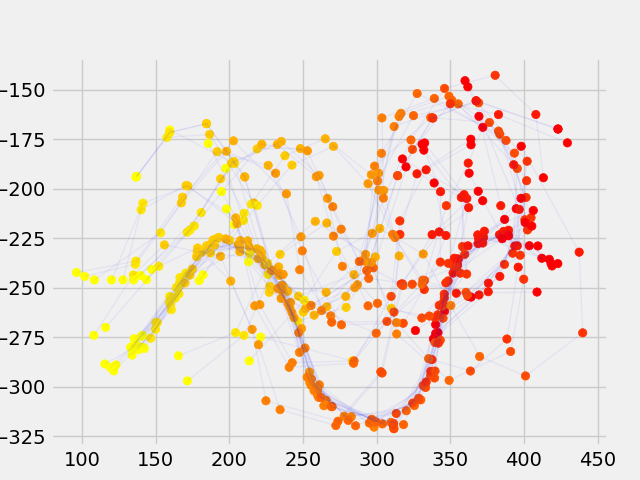

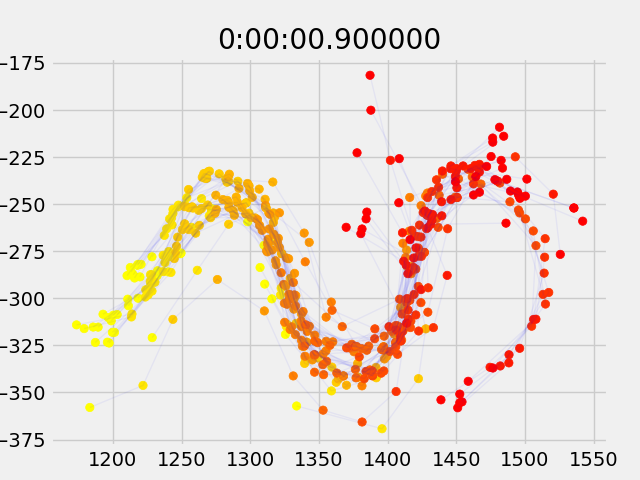

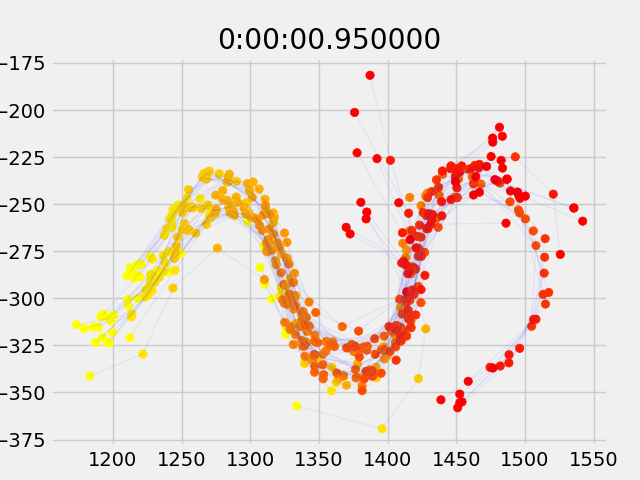

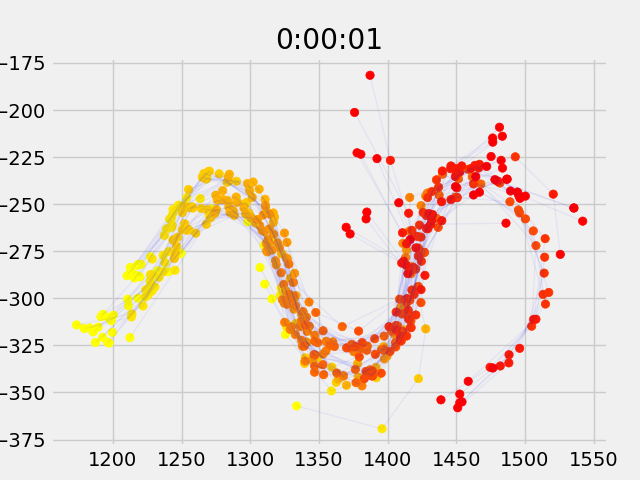

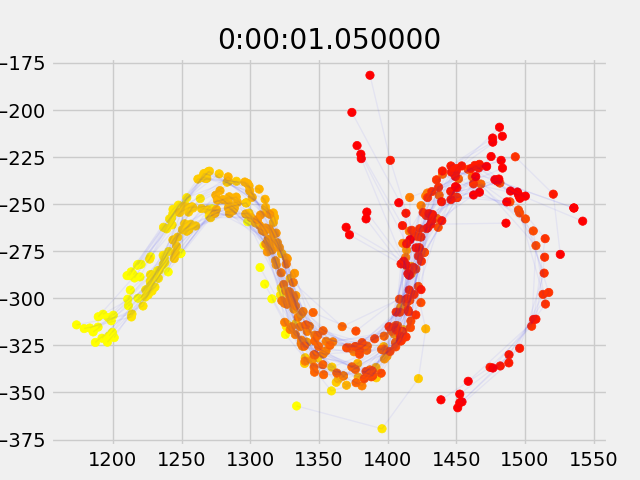

In [330]:
#plot posture
style.use('fivethirtyeight')
fig = plt.figure()#figsize=(25,5))
ax = fig.add_subplot(111)
start,end = 5950,6000#11700

# Create a list of colors for each segment of the line
col = np.arange(11)+20
for t in range(start,end):#np.shape(smoothed_arr)[0]):
    ax.plot(every_second_component(rowsArr_float2[t,:],1),every_second_component(-rowsArr_float2[t,:],0),lw=1,
            c='b',alpha=0.05)    
    ax.scatter(every_second_component(rowsArr_float2[t,:],1),every_second_component(-rowsArr_float2[t,:],0),
                   c=col,cmap='autumn')
ax.set_xlabel('x')

ax.set_ylabel('y')
plt.show()


#plot posture
style.use('fivethirtyeight')
fig = plt.figure()#figsize=(25,5))
ax = fig.add_subplot(111)
# Create a list of colors for each segment of the line
col = np.arange(11)+20
for t in range(start,end):#np.shape(smoothed_arr)[0]):
    ax.plot(every_second_component(t_xy_v1[t,1:],1),every_second_component(-t_xy_v1[t,1:],0),lw=1,
            c='b',alpha=0.05)    
    ax.scatter(every_second_component(t_xy_v1[t,1:],1),every_second_component(-t_xy_v1[t,1:],0),
                   c=col,cmap='autumn')
ax.set_xlabel('x')

ax.set_title(Delay1)
plt.show()

#plot posture
style.use('fivethirtyeight')
fig = plt.figure()#figsize=(25,5))
ax = fig.add_subplot(111)
col = np.arange(11)+20
for t in range(start,end):#np.shape(smoothed_arr)[0]):
    ax.plot(every_second_component(t_xy_vd2[t,1:],1),every_second_component(-t_xy_vd2[t,1:],0),lw=1,
            c='b',alpha=0.05)    
    ax.scatter(every_second_component(t_xy_vd2[t,1:],1),every_second_component(-t_xy_vd2[t,1:],0),
                   c=col,cmap='autumn')
ax.set_xlabel('x')

ax.set_title(Delay2)
plt.show()
#plot posture
style.use('fivethirtyeight')
fig = plt.figure()#figsize=(25,5))
ax = fig.add_subplot(111)
col = np.arange(11)+20
for t in range(start,end):#np.shape(smoothed_arr)[0]):
    ax.plot(every_second_component(t_xy_vd3[t,1:],1),every_second_component(-t_xy_vd3[t,1:],0),lw=1,
            c='b',alpha=0.05)    
    ax.scatter(every_second_component(t_xy_vd3[t,1:],1),every_second_component(-t_xy_vd3[t,1:],0),
                   c=col,cmap='autumn')
ax.set_xlabel('x')

ax.set_title(Delay3)
plt.show()
%matplotlib widget
#plot posture
style.use('fivethirtyeight')
fig = plt.figure()#figsize=(25,5))
ax = fig.add_subplot(111)
col = np.arange(11)+20
for t in range(start,end):#np.shape(smoothed_arr)[0]):
    ax.plot(every_second_component(t_xy_vd4[t,1:],1),every_second_component(-t_xy_vd4[t,1:],0),lw=1,
            c='b',alpha=0.05)    
    ax.scatter(every_second_component(t_xy_vd4[t,1:],1),every_second_component(-t_xy_vd4[t,1:],0),
                   c=col,cmap='autumn')
ax.set_xlabel('x')

ax.set_title(Delay4)
plt.show()

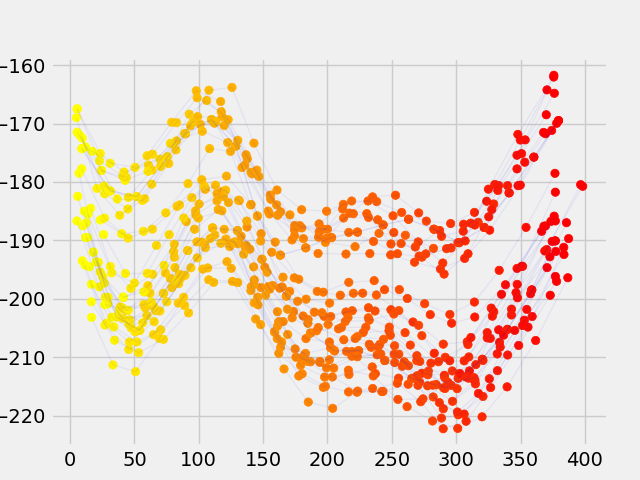

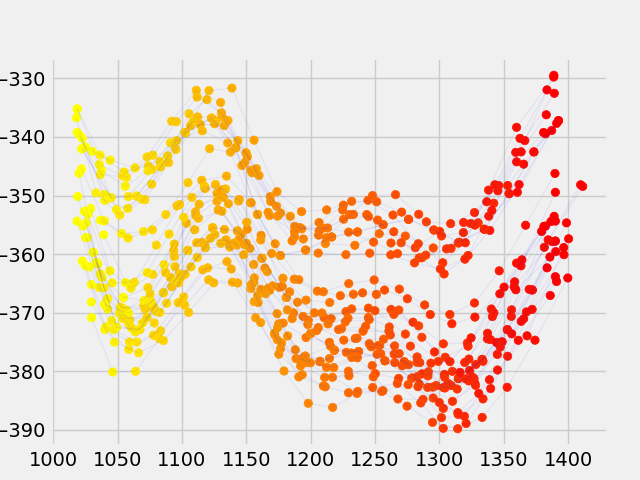

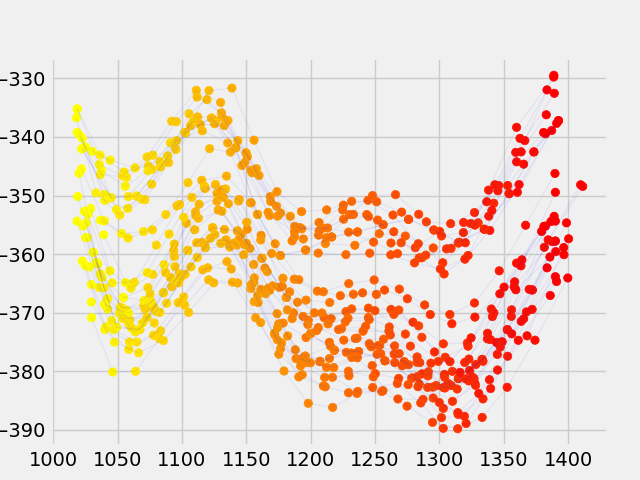

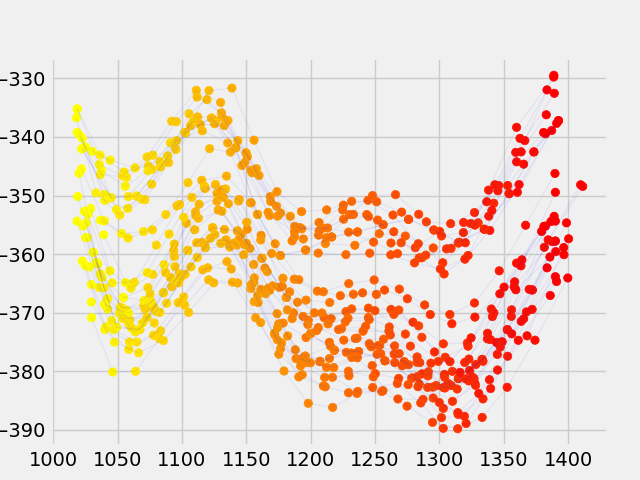

In [151]:
#plot posture
style.use('fivethirtyeight')
fig = plt.figure()#figsize=(25,5))
ax = fig.add_subplot(111)
# Create a list of colors for each segment of the line
col = np.arange(20)
for t in range(start,end):#np.shape(smoothed_arr)[0]):
    ax.plot(every_second_component(extended20matrixsmooth[t,:],1),every_second_component(-extended20matrixsmooth[t,:],0),lw=1,
            c='b',alpha=0.05)    
    ax.scatter(every_second_component(extended20matrixsmooth[t,:],1),every_second_component(-extended20matrixsmooth[t,:],0),
                   c=col,cmap='autumn')
ax.set_xlabel('x')

ax.set_ylabel('y')
plt.show()



#plot posture
style.use('fivethirtyeight')
fig = plt.figure()#figsize=(25,5))
ax = fig.add_subplot(111)
# Create a list of colors for each segment of the line
col = np.arange(20)+20
for t in range(start,end):#np.shape(smoothed_arr)[0]):
    ax.plot(every_second_component(t_xy_v1_ext[t,1:],1),every_second_component(-t_xy_v1_ext[t,1:],0),lw=1,
            c='b',alpha=0.05)    
    ax.scatter(every_second_component(t_xy_v1_ext[t,1:],1),every_second_component(-t_xy_v1_ext[t,1:],0),
                   c=col,cmap='autumn')
ax.set_xlabel('x')

ax.set_ylabel('y')
ax.set_ylabel(Delay2)
plt.show()

#plot posture
style.use('fivethirtyeight')
fig = plt.figure()#figsize=(25,5))
ax = fig.add_subplot(111)
# Create a list of colors for each segment of the line
col = np.arange(20)+20
for t in range(start,end):#np.shape(smoothed_arr)[0]):
    ax.plot(every_second_component(t_xy_vd2_ext[t,1:],1),every_second_component(-t_xy_vd2_ext[t,1:],0),lw=1,
            c='b',alpha=0.05)    
    ax.scatter(every_second_component(t_xy_vd2_ext[t,1:],1),every_second_component(-t_xy_vd2_ext[t,1:],0),
                   c=col,cmap='autumn')
ax.set_xlabel('x')

ax.set_ylabel('y')
ax.set_ylabel(Delay3)
plt.show()
#plot posture
style.use('fivethirtyeight')
fig = plt.figure()#figsize=(25,5))
ax = fig.add_subplot(111)
# Create a list of colors for each segment of the line
col = np.arange(20)+20
for t in range(start,end):#np.shape(smoothed_arr)[0]):
    ax.plot(every_second_component(t_xy_vd3_ext[t,1:],1),every_second_component(-t_xy_vd3_ext[t,1:],0),lw=1,
            c='b',alpha=0.05)    
    ax.scatter(every_second_component(t_xy_vd3_ext[t,1:],1),every_second_component(-t_xy_vd3_ext[t,1:],0),
                   c=col,cmap='autumn')
ax.set_xlabel('x')

ax.set_ylabel('y')
ax.set_ylabel(Delay4)
plt.show()